In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size = batch_size, valid=10000, transform=mnist_tanh)

fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.cuda()

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_size=32, batchnorm=False, dropout=False, **optim_params):
        super().__init__()
    
        self.latent_size = latent_size
        
        self.conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self.conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self.conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fc = FullyConnected([32*2*2, latent_size])
        
        self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1,32*2*2)
        x = self.fc(x)
        return x


In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_size=32, batchnorm=False, dropout=False, **optim_params):
        super().__init__()
    
        self.latent_size = latent_size
        
        self.fc = FullyConnected([latent_size, 32*2*2])
        
        self.deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self.deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self.deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self.optim = optim.Adam(self.parameters(), **optim_params)
  
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 32, 2, 2)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        return x
    

In [11]:
class Discriminator(nn.Module):
    def __init__(self, sizes, batchnorm=False, dropout=False, **optim_params):
        super().__init__()
        
        self.fc = FullyConnected(sizes, dropout=dropout, 
                                  activation_fn=nn.LeakyReLU(0.2), 
                                  flatten=True).cuda()
        
        self.optim = optim.Adam(self.fc.parameters(), **optim_params)
        
    def forward(self, x):
        return self.fc(x)
        
    

In [12]:
torch.manual_seed(42)

latent_size = 2

encoder = Encoder(latent_size, batchnorm=False, dropout=0.2, lr=1e-4).cuda()
decoder = Decoder(latent_size, batchnorm=False, dropout=0.2, lr=1e-4).cuda()
D = Discriminator([latent_size, 32, 1], batchnorm=False, dropout=False, lr=1e-4).cuda()

train_log = []
test_log = []

batch_zeros = torch.zeros((batch_size, 1)).cuda()
batch_ones = torch.ones((batch_size, 1)).cuda()

fixed_z = torch.randn((batch_size, latent_size)).cuda()


In [13]:
print(encoder)
print(decoder)
print(D)

Encoder(
  (conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
  )
  (conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
  )
  (conv3): ConvLayer(
    (model): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
  )
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=2, bias=True)
    )
  )
)
Decoder(
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
    )
  )
  (deconv1): DeconvLayer(
    (model): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
  )
  (deconv2): DeconvLayer(
    (model): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
      (1): ReLU()
    )
  )
  (deconv3

In [14]:
def train(epoch, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        
        # Discriminator
        
        encoder.optim.zero_grad()
        decoder.optim.zero_grad()
        D.optim.zero_grad()
        
        z = torch.randn((batch_size, latent_size)).cuda()
        h = encoder(data)
        fake_pred = D(h)
        true_pred = D(z)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D.optim.step()
        
        # Reconstruction
        
        encoder.optim.zero_grad()
        decoder.optim.zero_grad()
        D.optim.zero_grad()
        
        h = encoder(data)
        output = decoder(h)
        fake_pred = D(h)
        
        R_loss = F.mse_loss(output, data, size_average=True) + F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        R_loss.backward()
        encoder.optim.step()
        decoder.optim.step()
        
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' R = {:.4f}, D = {:.4f}'.format(R_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' R = {:.4f}, D = {:.4f}'.format(R_loss.item(), D_loss.item())
        if log is not None:
            log.append((R_loss.item(), D_loss.item()))
        print(line + losses)

In [15]:
def test(loader, epoch, log=None):
    test_size = len(loader)
    test_R_loss = 0.0
    test_D_loss = 0.0
    with torch.no_grad():
        for data, _ in loader:
            data = data.cuda()
            
            h = encoder(data)
            output = decoder(h)
            
            z = torch.randn((batch_size, latent_size)).cuda()
            
            fake_pred = D(h)
            true_pred = D(z)
            
            R_loss = F.mse_loss(output, data, size_average=True) + F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
            
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
            D_loss = 0.5*(fake_loss + true_loss)
            
            test_R_loss += R_loss.item()
            test_D_loss += D_loss.item()

    test_R_loss /= test_size
    test_D_loss /= test_size
    report = 'Test losses: {:.4f}/{:.4f}\n'.format(test_R_loss, test_D_loss)

    if log is not None:
        log.append((test_R_loss, test_D_loss))
    with torch.no_grad():
        ae_data = decoder(encoder(fixed_data))
        ae_data = ae_data.data.cpu().numpy()
        fixed_gen = decoder(fixed_z).data.cpu().numpy()
        plot_mnist(ae_data, (5, 10))
        plot_mnist(fixed_gen, (5, 10))
    print(report)

In [16]:
def plot(train, test):
    plt.figure(figsize=(12,6))
    plt.plot(train[0], color='green', label="R - train")
    plt.plot(test[0], color='green', label="R - test", marker='o')
    plt.plot(train[1], color='blue', label="D - train")
    plt.plot(test[1], color='blue', label="D - test", marker='o')
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    

/cephfs/home/seliverstov/oml/env/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses  R = 1.4875, D = 0.7099
Train Epoch: 1 [10000/50000 (20%)]	Losses  R = 1.2727, D = 0.6096
Train Epoch: 1 [20000/50000 (40%)]	Losses  R = 1.0992, D = 0.6701
Train Epoch: 1 [30000/50000 (60%)]	Losses  R = 1.0454, D = 0.6820
Train Epoch: 1 [40000/50000 (80%)]	Losses  R = 0.9390, D = 0.7500
Train Epoch: 1 [50000/50000 (100%)]	Losses  R = 1.0228, D = 0.6956


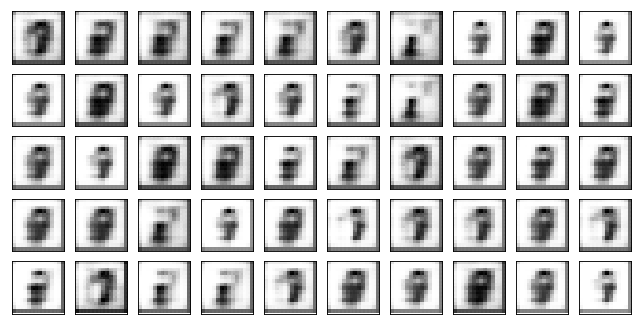

Test losses: 1.0202/0.6980

Train Epoch: 2 [0/50000 (0%)]	Losses  R = 1.0362, D = 0.6964
Train Epoch: 2 [10000/50000 (20%)]	Losses  R = 0.9942, D = 0.6995
Train Epoch: 2 [20000/50000 (40%)]	Losses  R = 0.9621, D = 0.7113
Train Epoch: 2 [30000/50000 (60%)]	Losses  R = 0.9625, D = 0.6957
Train Epoch: 2 [40000/50000 (80%)]	Losses  R = 0.9299, D = 0.6955
Train Epoch: 2 [50000/50000 (100%)]	Losses  R = 0.9298, D = 0.6958


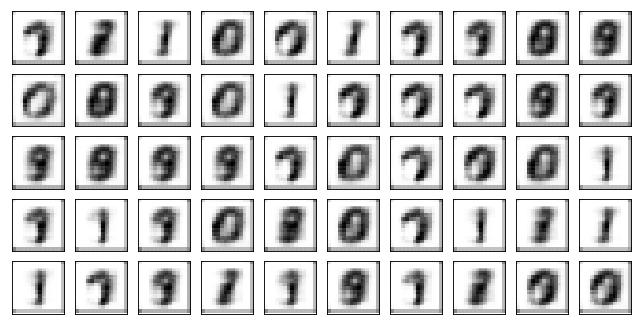

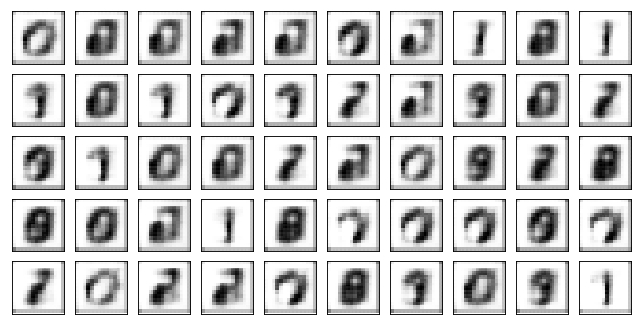

Test losses: 0.9285/0.6972

Train Epoch: 3 [0/50000 (0%)]	Losses  R = 0.9266, D = 0.6978
Train Epoch: 3 [10000/50000 (20%)]	Losses  R = 0.9383, D = 0.6948
Train Epoch: 3 [20000/50000 (40%)]	Losses  R = 0.9205, D = 0.6920
Train Epoch: 3 [30000/50000 (60%)]	Losses  R = 0.8956, D = 0.6973
Train Epoch: 3 [40000/50000 (80%)]	Losses  R = 0.8988, D = 0.6946
Train Epoch: 3 [50000/50000 (100%)]	Losses  R = 0.9015, D = 0.6927


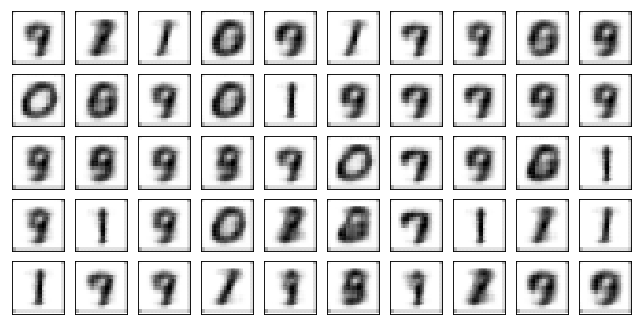

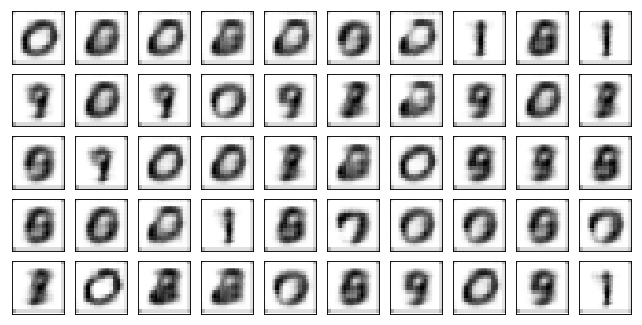

Test losses: 0.9135/0.6941

Train Epoch: 4 [0/50000 (0%)]	Losses  R = 0.9269, D = 0.6936
Train Epoch: 4 [10000/50000 (20%)]	Losses  R = 0.8942, D = 0.6942
Train Epoch: 4 [20000/50000 (40%)]	Losses  R = 0.9252, D = 0.6950
Train Epoch: 4 [30000/50000 (60%)]	Losses  R = 0.8900, D = 0.6940
Train Epoch: 4 [40000/50000 (80%)]	Losses  R = 0.8905, D = 0.6954
Train Epoch: 4 [50000/50000 (100%)]	Losses  R = 0.9025, D = 0.6952


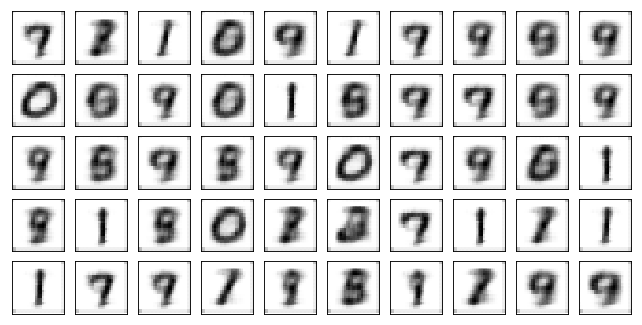

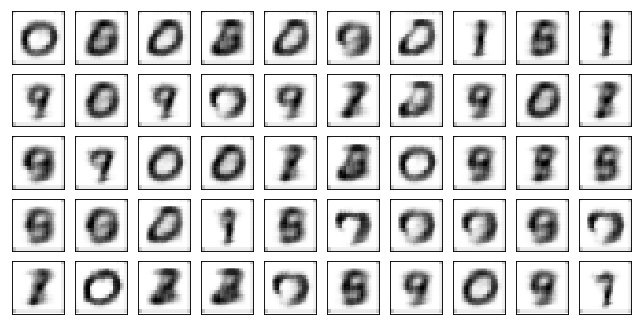

Test losses: 0.8997/0.6943

Train Epoch: 5 [0/50000 (0%)]	Losses  R = 0.8998, D = 0.6931
Train Epoch: 5 [10000/50000 (20%)]	Losses  R = 0.8849, D = 0.6952
Train Epoch: 5 [20000/50000 (40%)]	Losses  R = 0.9273, D = 0.6926
Train Epoch: 5 [30000/50000 (60%)]	Losses  R = 0.9053, D = 0.6949
Train Epoch: 5 [40000/50000 (80%)]	Losses  R = 0.8771, D = 0.6930
Train Epoch: 5 [50000/50000 (100%)]	Losses  R = 0.9019, D = 0.6936


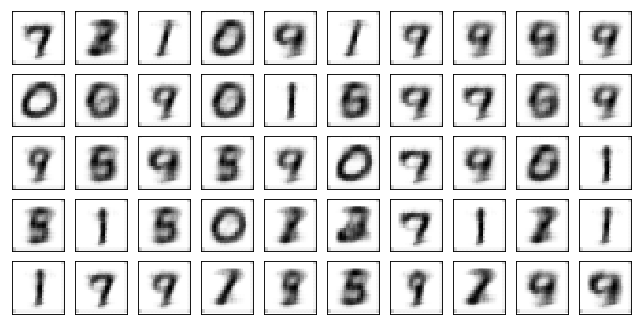

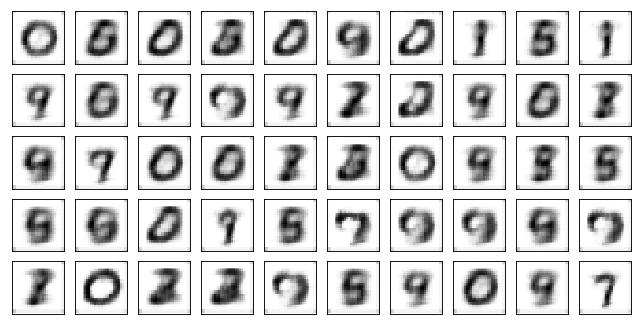

Test losses: 0.8943/0.6936

Train Epoch: 6 [0/50000 (0%)]	Losses  R = 0.8836, D = 0.6936
Train Epoch: 6 [10000/50000 (20%)]	Losses  R = 0.8878, D = 0.6930
Train Epoch: 6 [20000/50000 (40%)]	Losses  R = 0.8772, D = 0.6944
Train Epoch: 6 [30000/50000 (60%)]	Losses  R = 0.8886, D = 0.6932
Train Epoch: 6 [40000/50000 (80%)]	Losses  R = 0.8956, D = 0.6942
Train Epoch: 6 [50000/50000 (100%)]	Losses  R = 0.9020, D = 0.6928


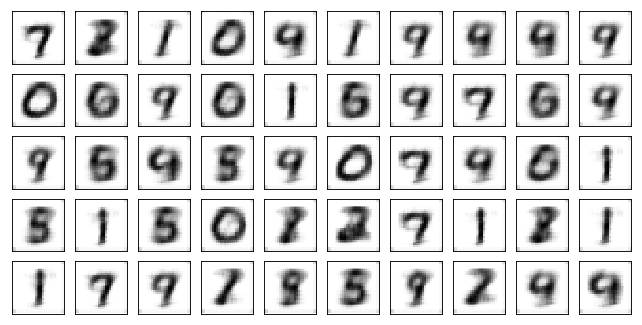

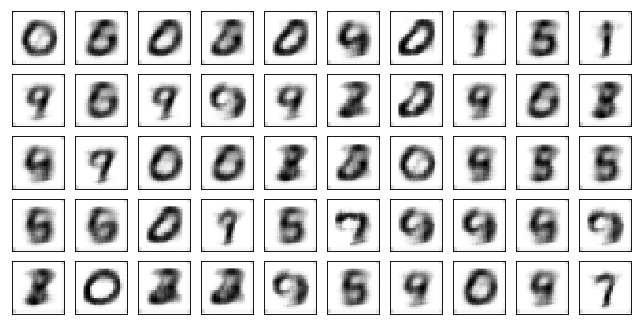

Test losses: 0.8898/0.6937

Train Epoch: 7 [0/50000 (0%)]	Losses  R = 0.8923, D = 0.6928
Train Epoch: 7 [10000/50000 (20%)]	Losses  R = 0.8829, D = 0.6942
Train Epoch: 7 [20000/50000 (40%)]	Losses  R = 0.8980, D = 0.6934
Train Epoch: 7 [30000/50000 (60%)]	Losses  R = 0.9013, D = 0.6931
Train Epoch: 7 [40000/50000 (80%)]	Losses  R = 0.8825, D = 0.6936
Train Epoch: 7 [50000/50000 (100%)]	Losses  R = 0.8873, D = 0.6933


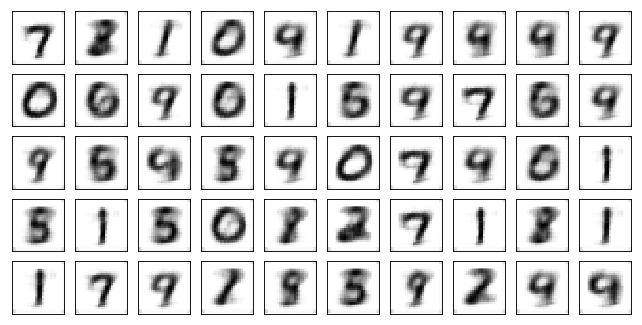

Test losses: 0.8866/0.6937

Train Epoch: 8 [0/50000 (0%)]	Losses  R = 0.8952, D = 0.6943
Train Epoch: 8 [10000/50000 (20%)]	Losses  R = 0.8846, D = 0.6941
Train Epoch: 8 [20000/50000 (40%)]	Losses  R = 0.8745, D = 0.6927
Train Epoch: 8 [30000/50000 (60%)]	Losses  R = 0.8881, D = 0.6938
Train Epoch: 8 [40000/50000 (80%)]	Losses  R = 0.8721, D = 0.6938
Train Epoch: 8 [50000/50000 (100%)]	Losses  R = 0.8809, D = 0.6938


Test losses: 0.8841/0.6936

Train Epoch: 9 [0/50000 (0%)]	Losses  R = 0.8760, D = 0.6935
Train Epoch: 9 [10000/50000 (20%)]	Losses  R = 0.8986, D = 0.6931
Train Epoch: 9 [20000/50000 (40%)]	Losses  R = 0.8899, D = 0.6936
Train Epoch: 9 [30000/50000 (60%)]	Losses  R = 0.8932, D = 0.6942
Train Epoch: 9 [40000/50000 (80%)]	Losses  R = 0.8847, D = 0.6942
Train Epoch: 9 [50000/50000 (100%)]	Losses  R = 0.8750, D = 0.6940


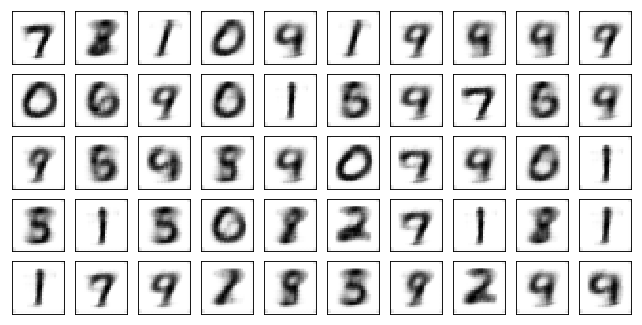

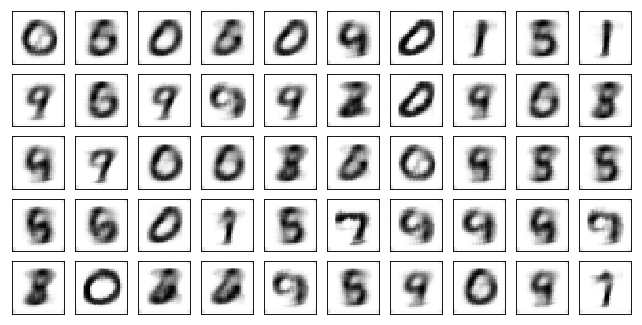

Test losses: 0.8817/0.6934

Train Epoch: 10 [0/50000 (0%)]	Losses  R = 0.8742, D = 0.6931
Train Epoch: 10 [10000/50000 (20%)]	Losses  R = 0.8869, D = 0.6934
Train Epoch: 10 [20000/50000 (40%)]	Losses  R = 0.8918, D = 0.6936
Train Epoch: 10 [30000/50000 (60%)]	Losses  R = 0.8953, D = 0.6939
Train Epoch: 10 [40000/50000 (80%)]	Losses  R = 0.8886, D = 0.6938
Train Epoch: 10 [50000/50000 (100%)]	Losses  R = 0.8756, D = 0.6928


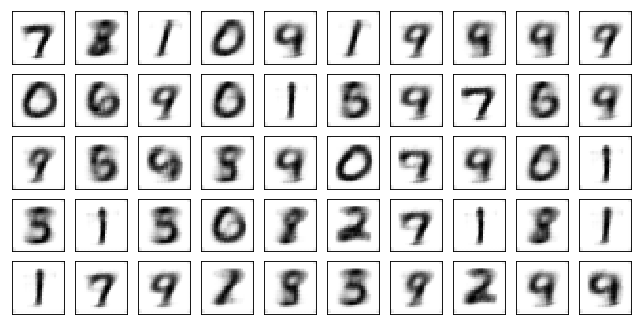

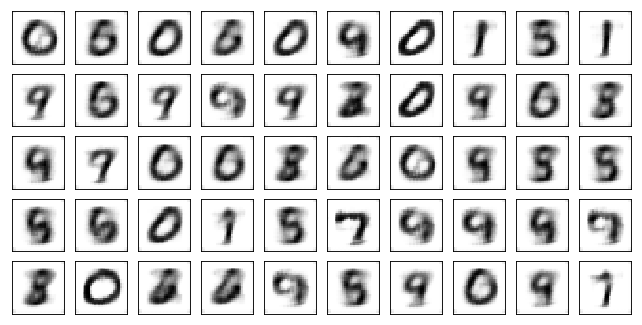

Test losses: 0.8802/0.6933



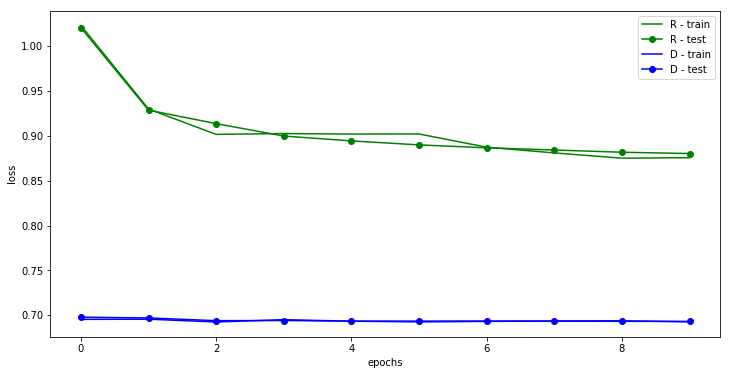

Train Epoch: 11 [0/50000 (0%)]	Losses  R = 0.8588, D = 0.6932
Train Epoch: 11 [10000/50000 (20%)]	Losses  R = 0.8679, D = 0.6938
Train Epoch: 11 [20000/50000 (40%)]	Losses  R = 0.8864, D = 0.6928
Train Epoch: 11 [30000/50000 (60%)]	Losses  R = 0.8865, D = 0.6933
Train Epoch: 11 [40000/50000 (80%)]	Losses  R = 0.8696, D = 0.6923
Train Epoch: 11 [50000/50000 (100%)]	Losses  R = 0.8687, D = 0.6935


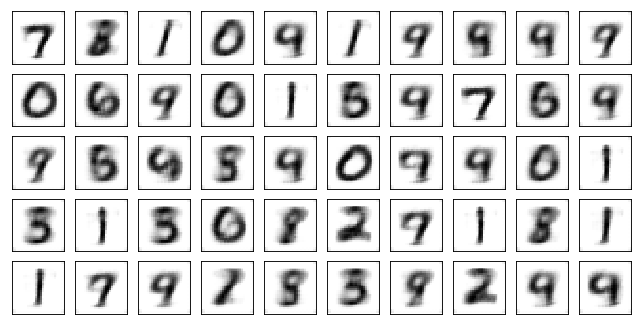

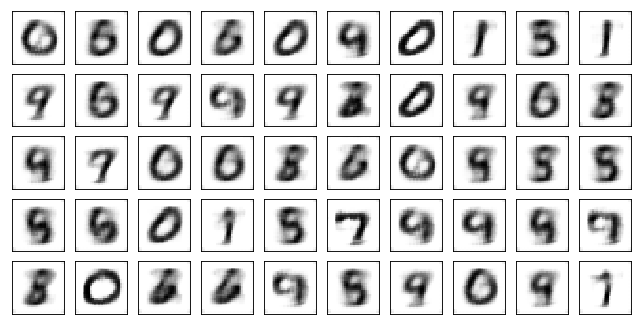

Test losses: 0.8786/0.6933

Train Epoch: 12 [0/50000 (0%)]	Losses  R = 0.8679, D = 0.6937
Train Epoch: 12 [10000/50000 (20%)]	Losses  R = 0.8796, D = 0.6941
Train Epoch: 12 [20000/50000 (40%)]	Losses  R = 0.8695, D = 0.6934
Train Epoch: 12 [30000/50000 (60%)]	Losses  R = 0.8666, D = 0.6929
Train Epoch: 12 [40000/50000 (80%)]	Losses  R = 0.8512, D = 0.6939
Train Epoch: 12 [50000/50000 (100%)]	Losses  R = 0.8776, D = 0.6930


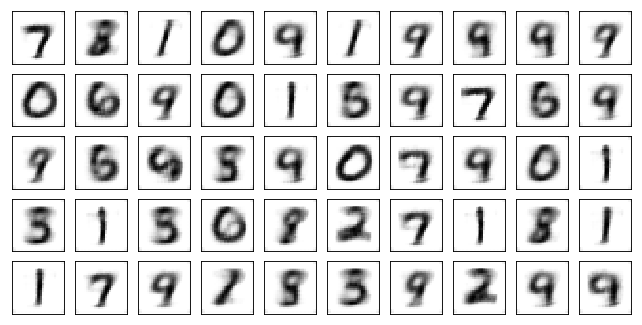

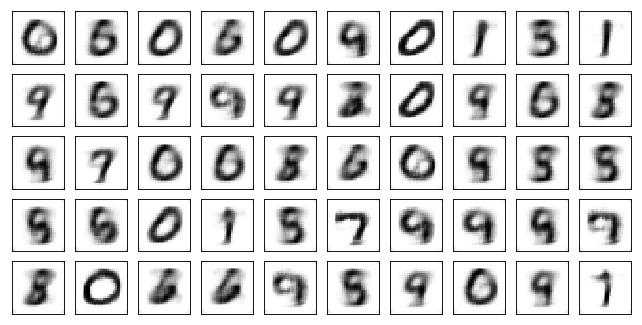

Test losses: 0.8781/0.6931

Train Epoch: 13 [0/50000 (0%)]	Losses  R = 0.8892, D = 0.6927
Train Epoch: 13 [10000/50000 (20%)]	Losses  R = 0.8810, D = 0.6932
Train Epoch: 13 [20000/50000 (40%)]	Losses  R = 0.8698, D = 0.6934
Train Epoch: 13 [30000/50000 (60%)]	Losses  R = 0.8690, D = 0.6929
Train Epoch: 13 [40000/50000 (80%)]	Losses  R = 0.8921, D = 0.6929
Train Epoch: 13 [50000/50000 (100%)]	Losses  R = 0.8809, D = 0.6927


Test losses: 0.8756/0.6930

Train Epoch: 14 [0/50000 (0%)]	Losses  R = 0.8776, D = 0.6920
Train Epoch: 14 [10000/50000 (20%)]	Losses  R = 0.8720, D = 0.6933
Train Epoch: 14 [20000/50000 (40%)]	Losses  R = 0.8980, D = 0.6929
Train Epoch: 14 [30000/50000 (60%)]	Losses  R = 0.8702, D = 0.6931
Train Epoch: 14 [40000/50000 (80%)]	Losses  R = 0.8767, D = 0.6917
Train Epoch: 14 [50000/50000 (100%)]	Losses  R = 0.8636, D = 0.6944


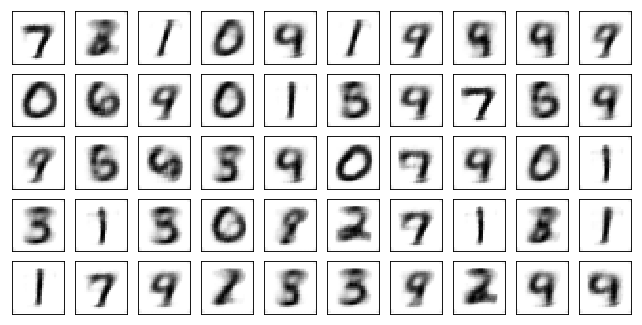

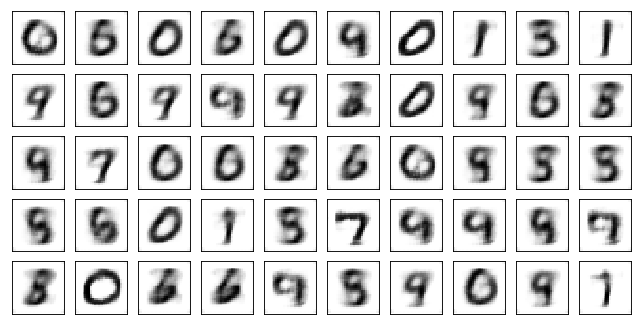

Test losses: 0.8752/0.6931

Train Epoch: 15 [0/50000 (0%)]	Losses  R = 0.8540, D = 0.6921
Train Epoch: 15 [10000/50000 (20%)]	Losses  R = 0.8669, D = 0.6936
Train Epoch: 15 [20000/50000 (40%)]	Losses  R = 0.8647, D = 0.6937
Train Epoch: 15 [30000/50000 (60%)]	Losses  R = 0.8773, D = 0.6932
Train Epoch: 15 [40000/50000 (80%)]	Losses  R = 0.8624, D = 0.6926
Train Epoch: 15 [50000/50000 (100%)]	Losses  R = 0.8764, D = 0.6922


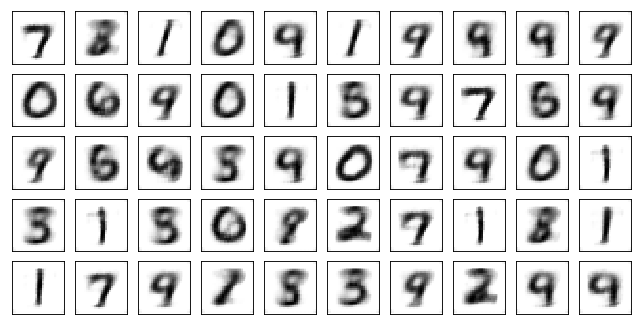

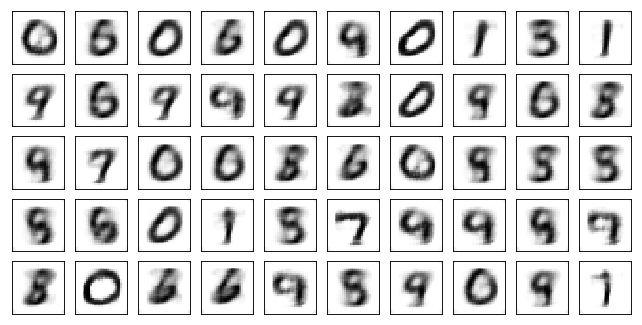

Test losses: 0.8736/0.6930

Train Epoch: 16 [0/50000 (0%)]	Losses  R = 0.8900, D = 0.6931
Train Epoch: 16 [10000/50000 (20%)]	Losses  R = 0.8744, D = 0.6932
Train Epoch: 16 [20000/50000 (40%)]	Losses  R = 0.8725, D = 0.6936
Train Epoch: 16 [30000/50000 (60%)]	Losses  R = 0.8723, D = 0.6930
Train Epoch: 16 [40000/50000 (80%)]	Losses  R = 0.8780, D = 0.6926
Train Epoch: 16 [50000/50000 (100%)]	Losses  R = 0.8710, D = 0.6929


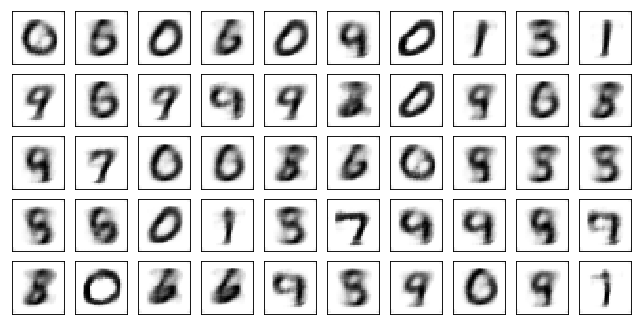

Test losses: 0.8727/0.6930

Train Epoch: 17 [0/50000 (0%)]	Losses  R = 0.8886, D = 0.6922
Train Epoch: 17 [10000/50000 (20%)]	Losses  R = 0.8630, D = 0.6933
Train Epoch: 17 [20000/50000 (40%)]	Losses  R = 0.8518, D = 0.6933
Train Epoch: 17 [30000/50000 (60%)]	Losses  R = 0.8598, D = 0.6937
Train Epoch: 17 [40000/50000 (80%)]	Losses  R = 0.8528, D = 0.6936
Train Epoch: 17 [50000/50000 (100%)]	Losses  R = 0.8769, D = 0.6935


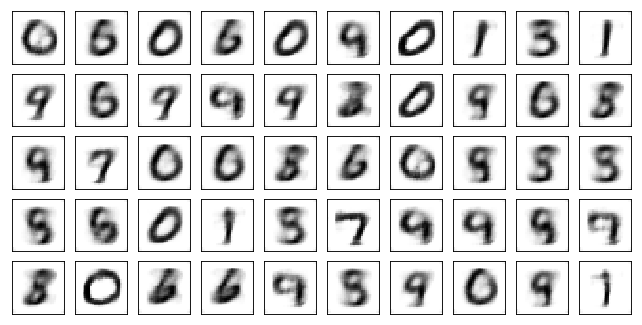

Test losses: 0.8724/0.6930

Train Epoch: 18 [0/50000 (0%)]	Losses  R = 0.8731, D = 0.6936
Train Epoch: 18 [10000/50000 (20%)]	Losses  R = 0.8892, D = 0.6939
Train Epoch: 18 [20000/50000 (40%)]	Losses  R = 0.8635, D = 0.6934
Train Epoch: 18 [30000/50000 (60%)]	Losses  R = 0.8682, D = 0.6926
Train Epoch: 18 [40000/50000 (80%)]	Losses  R = 0.8692, D = 0.6937
Train Epoch: 18 [50000/50000 (100%)]	Losses  R = 0.8846, D = 0.6929


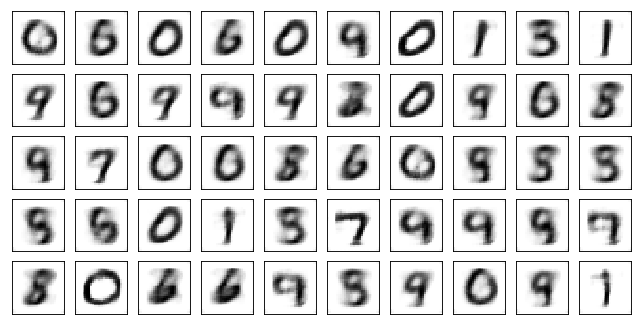

Test losses: 0.8717/0.6930

Train Epoch: 19 [0/50000 (0%)]	Losses  R = 0.8787, D = 0.6929
Train Epoch: 19 [10000/50000 (20%)]	Losses  R = 0.8620, D = 0.6920
Train Epoch: 19 [20000/50000 (40%)]	Losses  R = 0.8632, D = 0.6926
Train Epoch: 19 [30000/50000 (60%)]	Losses  R = 0.8560, D = 0.6932
Train Epoch: 19 [40000/50000 (80%)]	Losses  R = 0.8857, D = 0.6922
Train Epoch: 19 [50000/50000 (100%)]	Losses  R = 0.8768, D = 0.6915


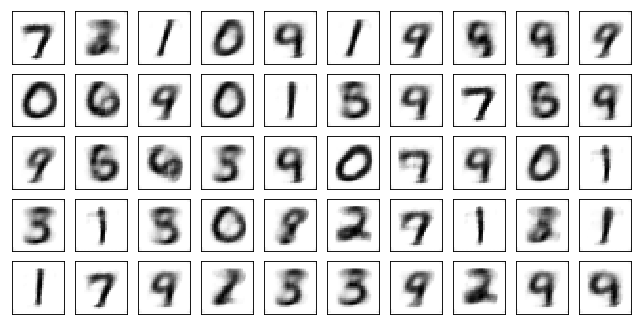

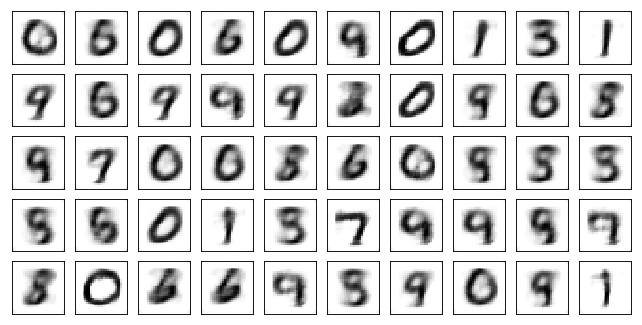

Test losses: 0.8713/0.6930

Train Epoch: 20 [0/50000 (0%)]	Losses  R = 0.8752, D = 0.6932
Train Epoch: 20 [10000/50000 (20%)]	Losses  R = 0.8504, D = 0.6931
Train Epoch: 20 [20000/50000 (40%)]	Losses  R = 0.8597, D = 0.6910
Train Epoch: 20 [30000/50000 (60%)]	Losses  R = 0.8707, D = 0.6951
Train Epoch: 20 [40000/50000 (80%)]	Losses  R = 0.8613, D = 0.6939
Train Epoch: 20 [50000/50000 (100%)]	Losses  R = 0.8936, D = 0.6925


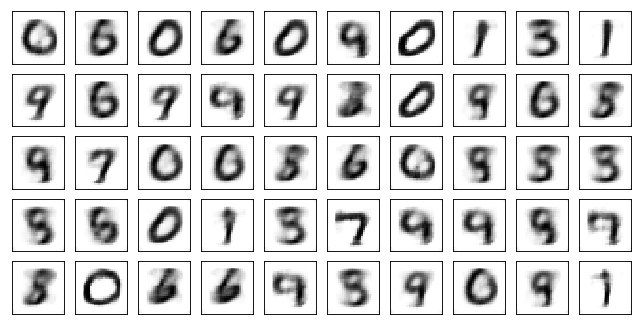

Test losses: 0.8697/0.6930



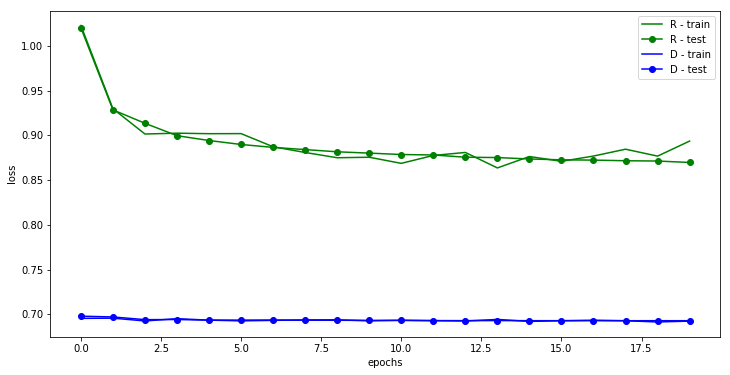

Train Epoch: 21 [0/50000 (0%)]	Losses  R = 0.8684, D = 0.6919
Train Epoch: 21 [10000/50000 (20%)]	Losses  R = 0.8781, D = 0.6949
Train Epoch: 21 [20000/50000 (40%)]	Losses  R = 0.8496, D = 0.6930
Train Epoch: 21 [30000/50000 (60%)]	Losses  R = 0.8638, D = 0.6923
Train Epoch: 21 [40000/50000 (80%)]	Losses  R = 0.8807, D = 0.6936
Train Epoch: 21 [50000/50000 (100%)]	Losses  R = 0.8905, D = 0.6920


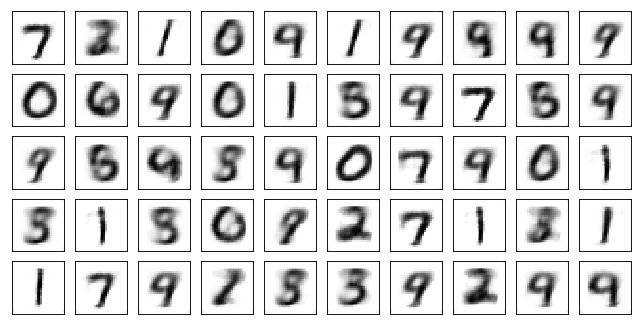

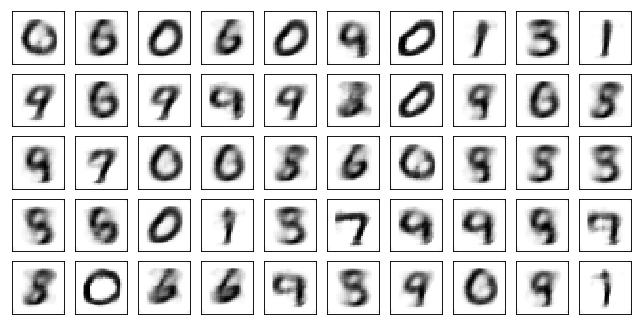

Test losses: 0.8696/0.6931

Train Epoch: 22 [0/50000 (0%)]	Losses  R = 0.8840, D = 0.6937
Train Epoch: 22 [10000/50000 (20%)]	Losses  R = 0.8857, D = 0.6928
Train Epoch: 22 [20000/50000 (40%)]	Losses  R = 0.8727, D = 0.6932
Train Epoch: 22 [30000/50000 (60%)]	Losses  R = 0.8525, D = 0.6934
Train Epoch: 22 [40000/50000 (80%)]	Losses  R = 0.8602, D = 0.6934
Train Epoch: 22 [50000/50000 (100%)]	Losses  R = 0.8802, D = 0.6928


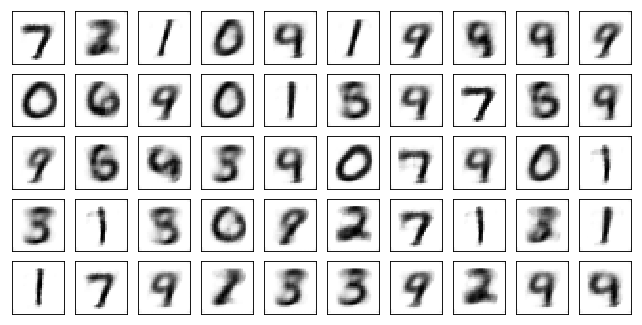

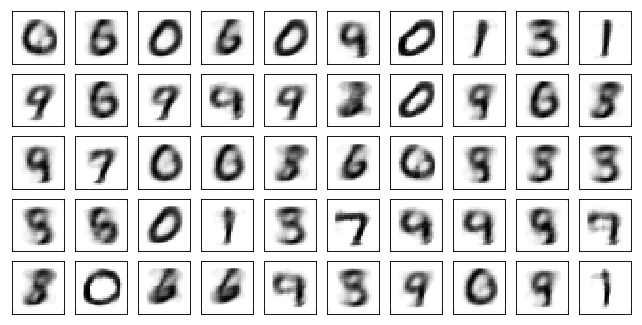

Test losses: 0.8683/0.6929

Train Epoch: 23 [0/50000 (0%)]	Losses  R = 0.8719, D = 0.6931
Train Epoch: 23 [10000/50000 (20%)]	Losses  R = 0.8599, D = 0.6931
Train Epoch: 23 [20000/50000 (40%)]	Losses  R = 0.9054, D = 0.6934
Train Epoch: 23 [30000/50000 (60%)]	Losses  R = 0.8701, D = 0.6924
Train Epoch: 23 [40000/50000 (80%)]	Losses  R = 0.8693, D = 0.6924
Train Epoch: 23 [50000/50000 (100%)]	Losses  R = 0.8662, D = 0.6936


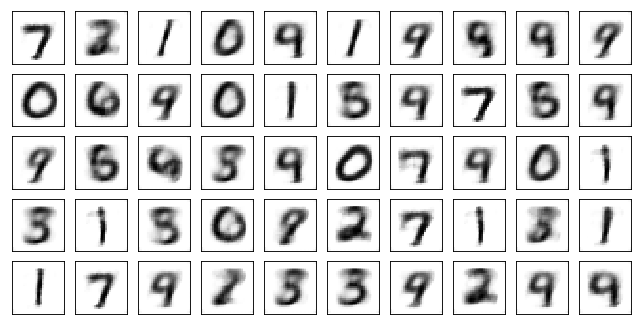

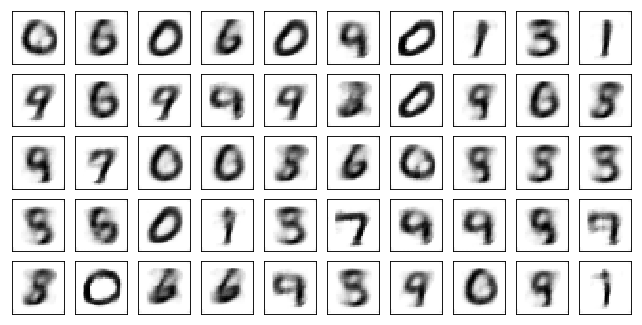

Test losses: 0.8679/0.6929

Train Epoch: 24 [0/50000 (0%)]	Losses  R = 0.8594, D = 0.6938
Train Epoch: 24 [10000/50000 (20%)]	Losses  R = 0.8682, D = 0.6935
Train Epoch: 24 [20000/50000 (40%)]	Losses  R = 0.8762, D = 0.6924
Train Epoch: 24 [30000/50000 (60%)]	Losses  R = 0.9038, D = 0.6935
Train Epoch: 24 [40000/50000 (80%)]	Losses  R = 0.8833, D = 0.6927
Train Epoch: 24 [50000/50000 (100%)]	Losses  R = 0.8767, D = 0.6926


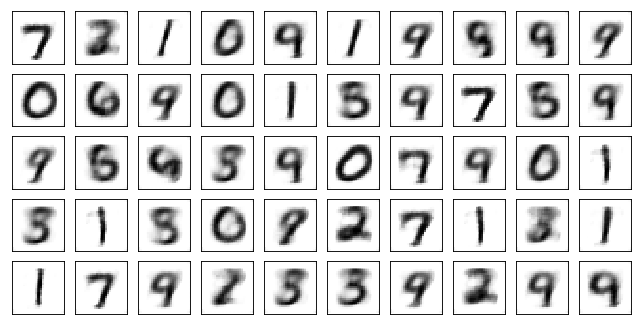

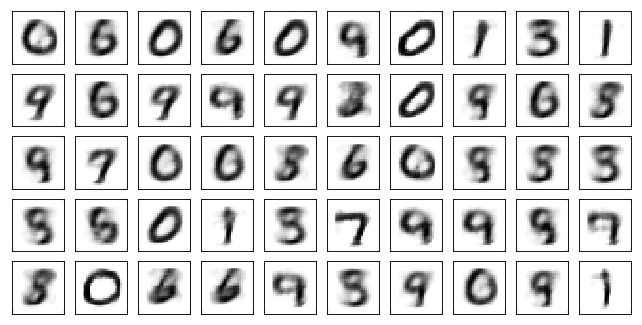

Test losses: 0.8666/0.6929

Train Epoch: 25 [0/50000 (0%)]	Losses  R = 0.8704, D = 0.6928
Train Epoch: 25 [10000/50000 (20%)]	Losses  R = 0.8540, D = 0.6934
Train Epoch: 25 [20000/50000 (40%)]	Losses  R = 0.8718, D = 0.6934
Train Epoch: 25 [30000/50000 (60%)]	Losses  R = 0.8836, D = 0.6924
Train Epoch: 25 [40000/50000 (80%)]	Losses  R = 0.8867, D = 0.6942
Train Epoch: 25 [50000/50000 (100%)]	Losses  R = 0.8625, D = 0.6942


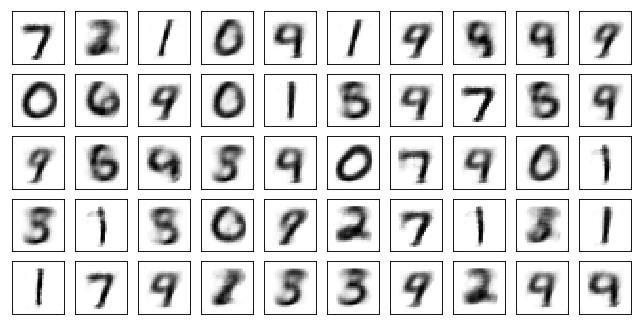

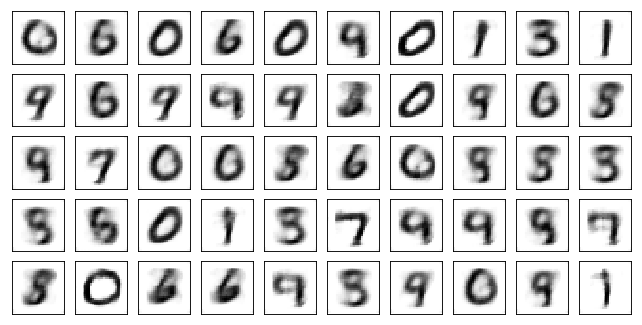

Test losses: 0.8671/0.6930

Train Epoch: 26 [0/50000 (0%)]	Losses  R = 0.8836, D = 0.6934
Train Epoch: 26 [10000/50000 (20%)]	Losses  R = 0.8606, D = 0.6934
Train Epoch: 26 [20000/50000 (40%)]	Losses  R = 0.8933, D = 0.6923
Train Epoch: 26 [30000/50000 (60%)]	Losses  R = 0.8733, D = 0.6926
Train Epoch: 26 [40000/50000 (80%)]	Losses  R = 0.8610, D = 0.6937
Train Epoch: 26 [50000/50000 (100%)]	Losses  R = 0.8635, D = 0.6929


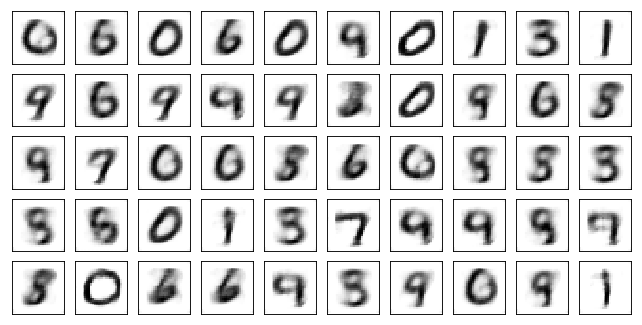

Test losses: 0.8664/0.6929

Train Epoch: 27 [0/50000 (0%)]	Losses  R = 0.8617, D = 0.6933
Train Epoch: 27 [10000/50000 (20%)]	Losses  R = 0.8738, D = 0.6928
Train Epoch: 27 [20000/50000 (40%)]	Losses  R = 0.8755, D = 0.6930
Train Epoch: 27 [30000/50000 (60%)]	Losses  R = 0.8588, D = 0.6936
Train Epoch: 27 [40000/50000 (80%)]	Losses  R = 0.8475, D = 0.6930
Train Epoch: 27 [50000/50000 (100%)]	Losses  R = 0.8969, D = 0.6925


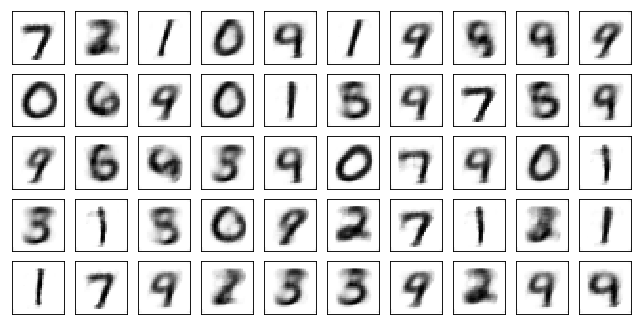

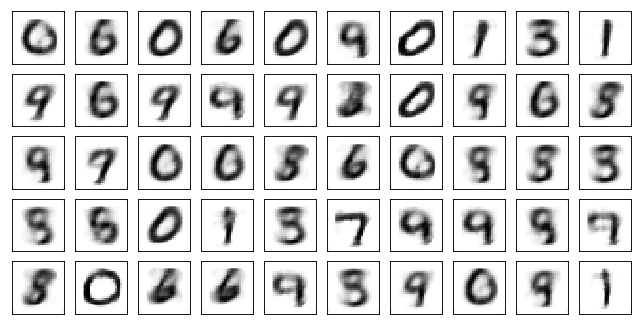

Test losses: 0.8663/0.6929

Train Epoch: 28 [0/50000 (0%)]	Losses  R = 0.8607, D = 0.6933
Train Epoch: 28 [10000/50000 (20%)]	Losses  R = 0.8534, D = 0.6932
Train Epoch: 28 [20000/50000 (40%)]	Losses  R = 0.8580, D = 0.6941
Train Epoch: 28 [30000/50000 (60%)]	Losses  R = 0.8832, D = 0.6939
Train Epoch: 28 [40000/50000 (80%)]	Losses  R = 0.8692, D = 0.6940
Train Epoch: 28 [50000/50000 (100%)]	Losses  R = 0.8749, D = 0.6936


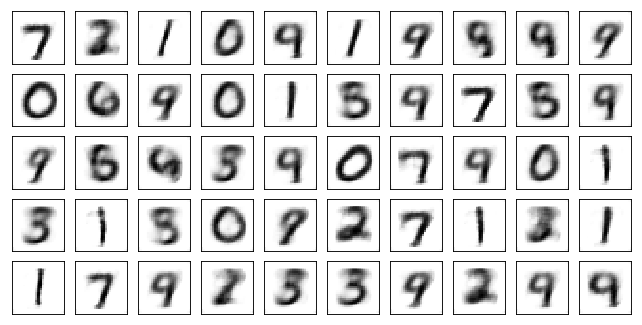

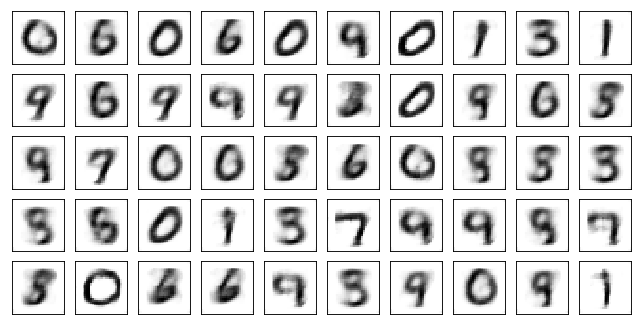

Test losses: 0.8649/0.6929

Train Epoch: 29 [0/50000 (0%)]	Losses  R = 0.8662, D = 0.6929
Train Epoch: 29 [10000/50000 (20%)]	Losses  R = 0.8746, D = 0.6935
Train Epoch: 29 [20000/50000 (40%)]	Losses  R = 0.8794, D = 0.6933
Train Epoch: 29 [30000/50000 (60%)]	Losses  R = 0.8709, D = 0.6926
Train Epoch: 29 [40000/50000 (80%)]	Losses  R = 0.8776, D = 0.6933
Train Epoch: 29 [50000/50000 (100%)]	Losses  R = 0.8777, D = 0.6929


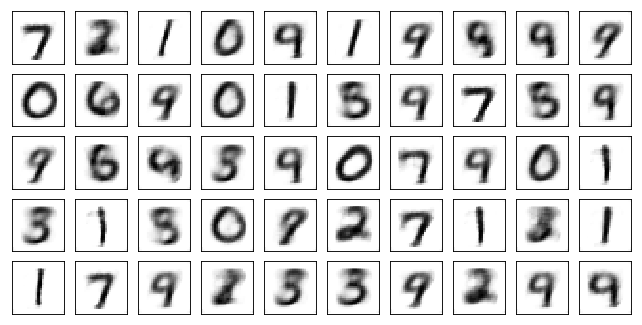

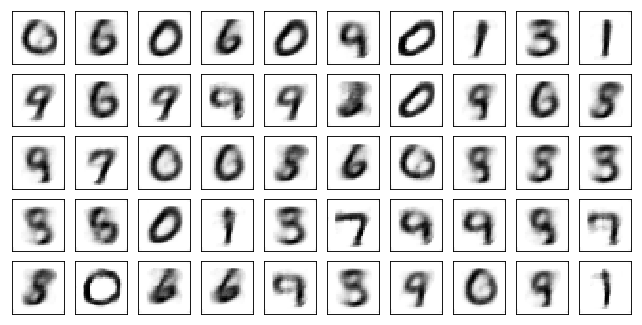

Test losses: 0.8649/0.6929

Train Epoch: 30 [0/50000 (0%)]	Losses  R = 0.8746, D = 0.6935
Train Epoch: 30 [10000/50000 (20%)]	Losses  R = 0.8761, D = 0.6921
Train Epoch: 30 [20000/50000 (40%)]	Losses  R = 0.8619, D = 0.6939
Train Epoch: 30 [30000/50000 (60%)]	Losses  R = 0.8666, D = 0.6933
Train Epoch: 30 [40000/50000 (80%)]	Losses  R = 0.8622, D = 0.6936
Train Epoch: 30 [50000/50000 (100%)]	Losses  R = 0.8645, D = 0.6929


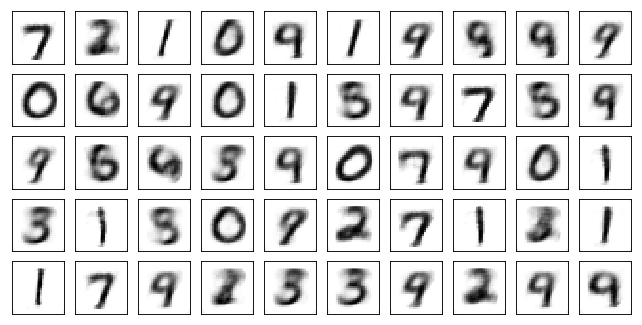

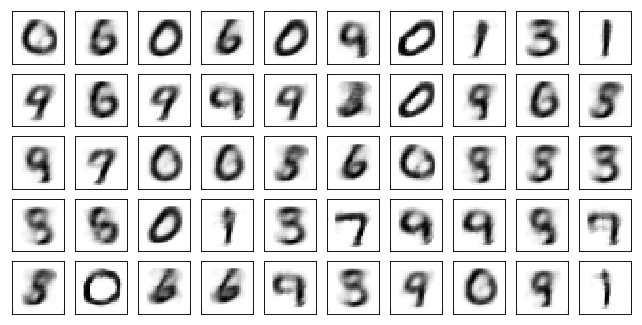

Test losses: 0.8645/0.6930



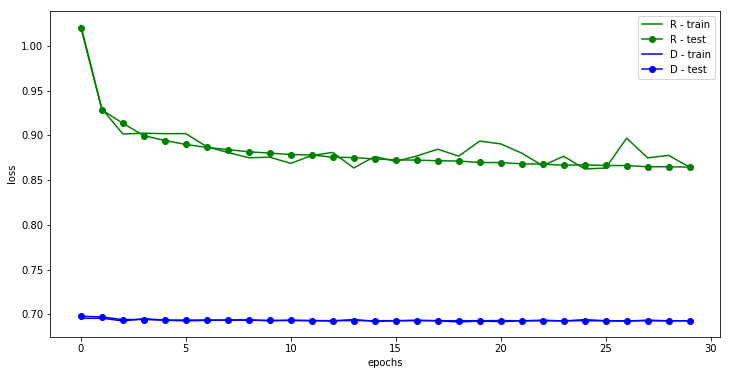

Train Epoch: 31 [0/50000 (0%)]	Losses  R = 0.8575, D = 0.6931
Train Epoch: 31 [10000/50000 (20%)]	Losses  R = 0.8536, D = 0.6933
Train Epoch: 31 [20000/50000 (40%)]	Losses  R = 0.8524, D = 0.6926
Train Epoch: 31 [30000/50000 (60%)]	Losses  R = 0.8501, D = 0.6932
Train Epoch: 31 [40000/50000 (80%)]	Losses  R = 0.8758, D = 0.6917
Train Epoch: 31 [50000/50000 (100%)]	Losses  R = 0.8613, D = 0.6936


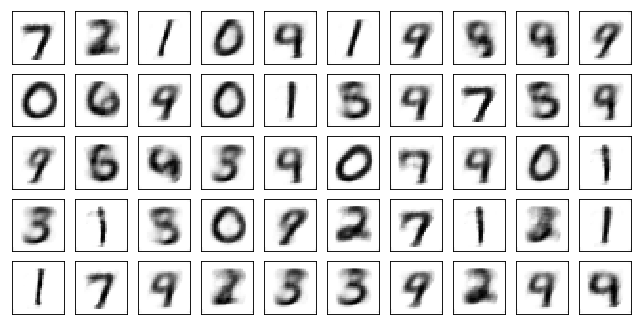

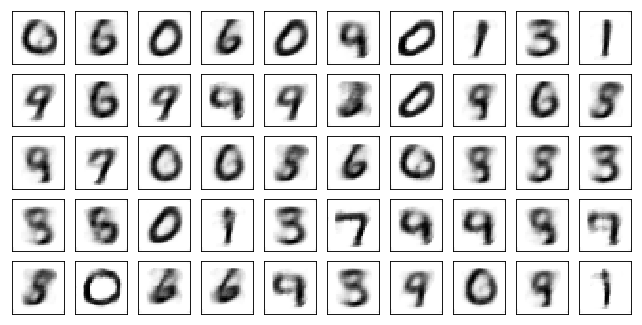

Test losses: 0.8635/0.6929

Train Epoch: 32 [0/50000 (0%)]	Losses  R = 0.8748, D = 0.6923
Train Epoch: 32 [10000/50000 (20%)]	Losses  R = 0.8605, D = 0.6926
Train Epoch: 32 [20000/50000 (40%)]	Losses  R = 0.8774, D = 0.6924
Train Epoch: 32 [30000/50000 (60%)]	Losses  R = 0.8617, D = 0.6930
Train Epoch: 32 [40000/50000 (80%)]	Losses  R = 0.8767, D = 0.6926
Train Epoch: 32 [50000/50000 (100%)]	Losses  R = 0.8763, D = 0.6930


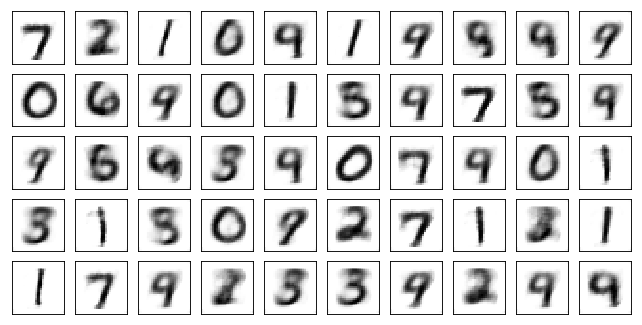

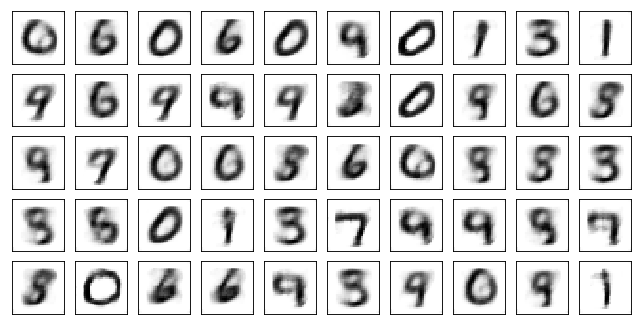

Test losses: 0.8633/0.6929

Train Epoch: 33 [0/50000 (0%)]	Losses  R = 0.8730, D = 0.6920
Train Epoch: 33 [10000/50000 (20%)]	Losses  R = 0.8756, D = 0.6940
Train Epoch: 33 [20000/50000 (40%)]	Losses  R = 0.8586, D = 0.6934
Train Epoch: 33 [30000/50000 (60%)]	Losses  R = 0.8629, D = 0.6937
Train Epoch: 33 [40000/50000 (80%)]	Losses  R = 0.8693, D = 0.6936
Train Epoch: 33 [50000/50000 (100%)]	Losses  R = 0.8704, D = 0.6938


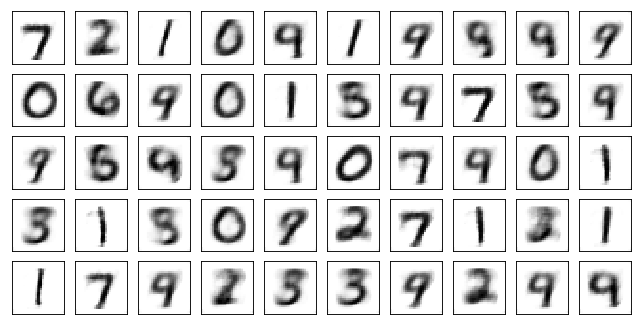

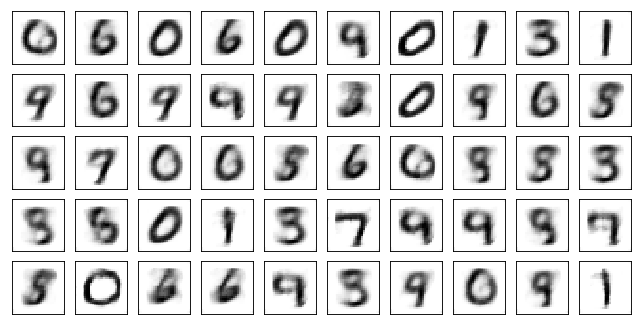

Test losses: 0.8634/0.6928

Train Epoch: 34 [0/50000 (0%)]	Losses  R = 0.8812, D = 0.6927
Train Epoch: 34 [10000/50000 (20%)]	Losses  R = 0.8633, D = 0.6924
Train Epoch: 34 [20000/50000 (40%)]	Losses  R = 0.8596, D = 0.6928
Train Epoch: 34 [30000/50000 (60%)]	Losses  R = 0.8583, D = 0.6923
Train Epoch: 34 [40000/50000 (80%)]	Losses  R = 0.8739, D = 0.6935
Train Epoch: 34 [50000/50000 (100%)]	Losses  R = 0.8794, D = 0.6931


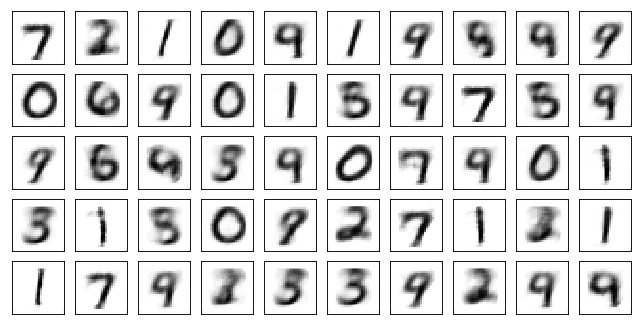

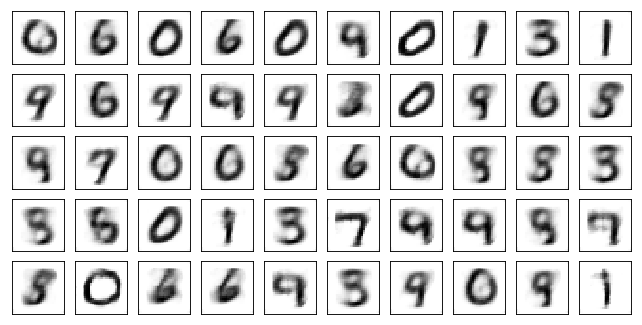

Test losses: 0.8637/0.6929

Train Epoch: 35 [0/50000 (0%)]	Losses  R = 0.8644, D = 0.6936
Train Epoch: 35 [10000/50000 (20%)]	Losses  R = 0.8648, D = 0.6936
Train Epoch: 35 [20000/50000 (40%)]	Losses  R = 0.8638, D = 0.6943
Train Epoch: 35 [30000/50000 (60%)]	Losses  R = 0.8521, D = 0.6931
Train Epoch: 35 [40000/50000 (80%)]	Losses  R = 0.8797, D = 0.6934
Train Epoch: 35 [50000/50000 (100%)]	Losses  R = 0.8543, D = 0.6931


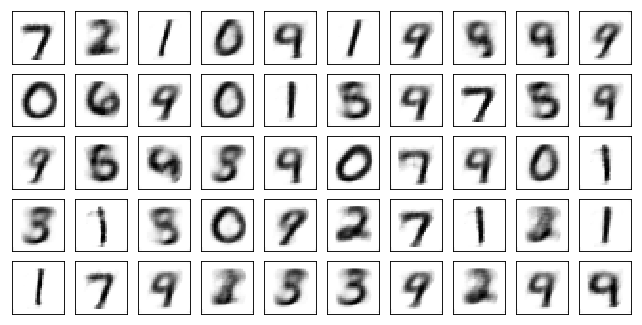

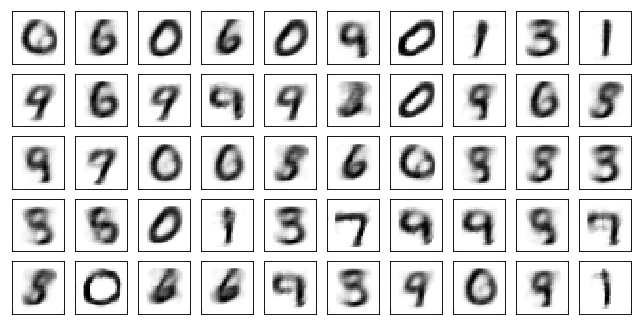

Test losses: 0.8627/0.6929

Train Epoch: 36 [0/50000 (0%)]	Losses  R = 0.8628, D = 0.6934
Train Epoch: 36 [10000/50000 (20%)]	Losses  R = 0.8613, D = 0.6937
Train Epoch: 36 [20000/50000 (40%)]	Losses  R = 0.8642, D = 0.6927
Train Epoch: 36 [30000/50000 (60%)]	Losses  R = 0.8633, D = 0.6932
Train Epoch: 36 [40000/50000 (80%)]	Losses  R = 0.8600, D = 0.6929
Train Epoch: 36 [50000/50000 (100%)]	Losses  R = 0.8598, D = 0.6934


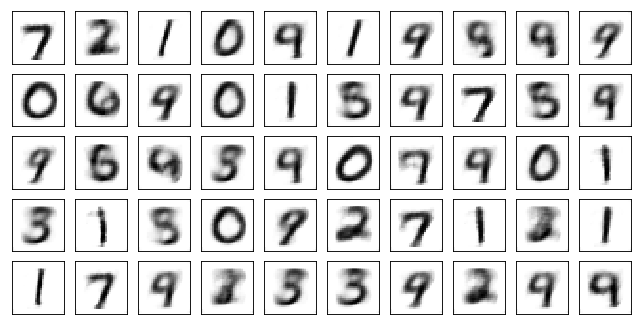

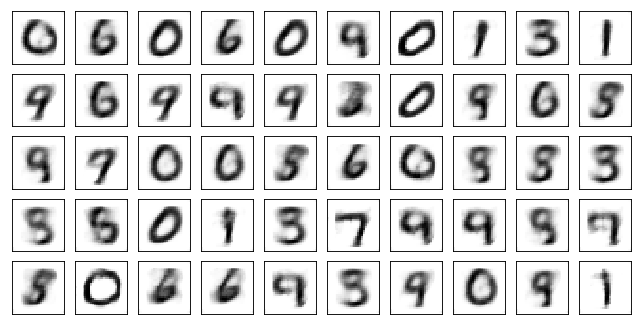

Test losses: 0.8620/0.6929

Train Epoch: 37 [0/50000 (0%)]	Losses  R = 0.8736, D = 0.6918
Train Epoch: 37 [10000/50000 (20%)]	Losses  R = 0.8558, D = 0.6920
Train Epoch: 37 [20000/50000 (40%)]	Losses  R = 0.8919, D = 0.6935
Train Epoch: 37 [30000/50000 (60%)]	Losses  R = 0.8647, D = 0.6922
Train Epoch: 37 [40000/50000 (80%)]	Losses  R = 0.8555, D = 0.6930
Train Epoch: 37 [50000/50000 (100%)]	Losses  R = 0.8601, D = 0.6930


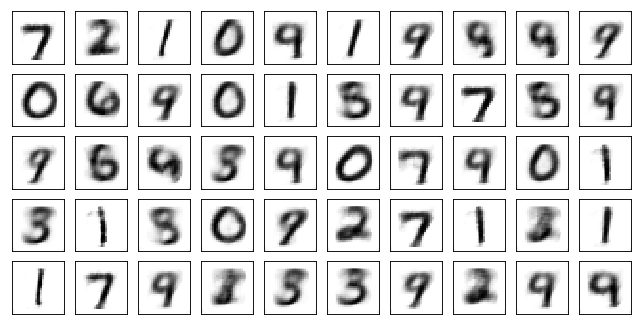

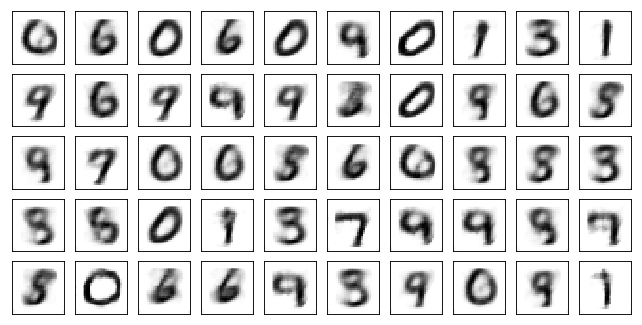

Test losses: 0.8619/0.6929

Train Epoch: 38 [0/50000 (0%)]	Losses  R = 0.8635, D = 0.6929
Train Epoch: 38 [10000/50000 (20%)]	Losses  R = 0.8687, D = 0.6925
Train Epoch: 38 [20000/50000 (40%)]	Losses  R = 0.8765, D = 0.6925
Train Epoch: 38 [30000/50000 (60%)]	Losses  R = 0.8493, D = 0.6936
Train Epoch: 38 [40000/50000 (80%)]	Losses  R = 0.8703, D = 0.6927
Train Epoch: 38 [50000/50000 (100%)]	Losses  R = 0.8715, D = 0.6927


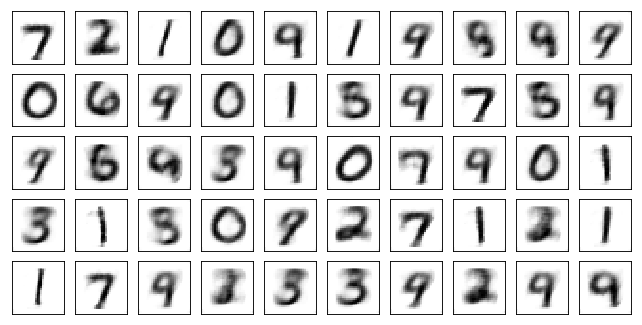

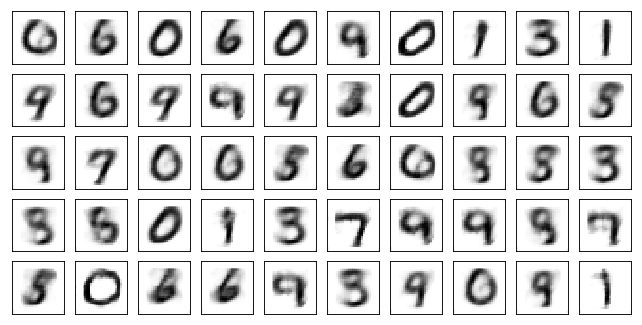

Test losses: 0.8622/0.6930

Train Epoch: 39 [0/50000 (0%)]	Losses  R = 0.8585, D = 0.6923
Train Epoch: 39 [10000/50000 (20%)]	Losses  R = 0.8729, D = 0.6930
Train Epoch: 39 [20000/50000 (40%)]	Losses  R = 0.8600, D = 0.6919
Train Epoch: 39 [30000/50000 (60%)]	Losses  R = 0.8665, D = 0.6934
Train Epoch: 39 [40000/50000 (80%)]	Losses  R = 0.8532, D = 0.6935
Train Epoch: 39 [50000/50000 (100%)]	Losses  R = 0.8643, D = 0.6917


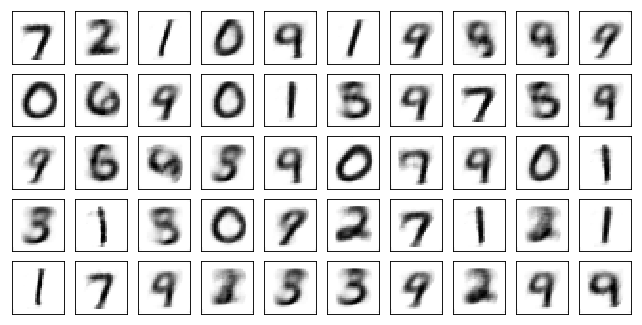

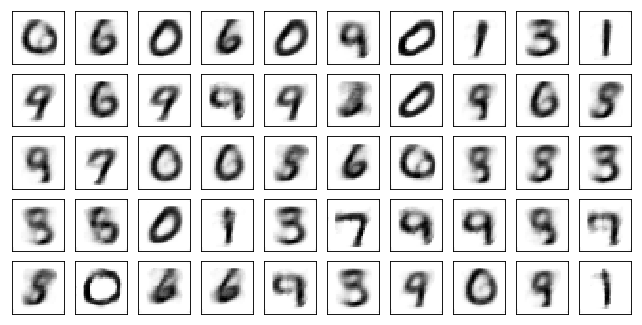

Test losses: 0.8619/0.6929

Train Epoch: 40 [0/50000 (0%)]	Losses  R = 0.8531, D = 0.6927
Train Epoch: 40 [10000/50000 (20%)]	Losses  R = 0.8652, D = 0.6934
Train Epoch: 40 [20000/50000 (40%)]	Losses  R = 0.8533, D = 0.6931
Train Epoch: 40 [30000/50000 (60%)]	Losses  R = 0.8465, D = 0.6941
Train Epoch: 40 [40000/50000 (80%)]	Losses  R = 0.8627, D = 0.6924
Train Epoch: 40 [50000/50000 (100%)]	Losses  R = 0.8539, D = 0.6932


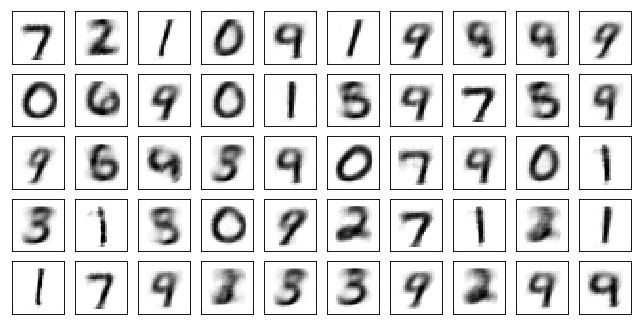

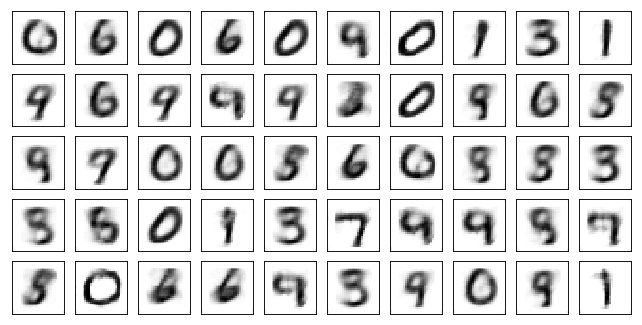

Test losses: 0.8609/0.6927



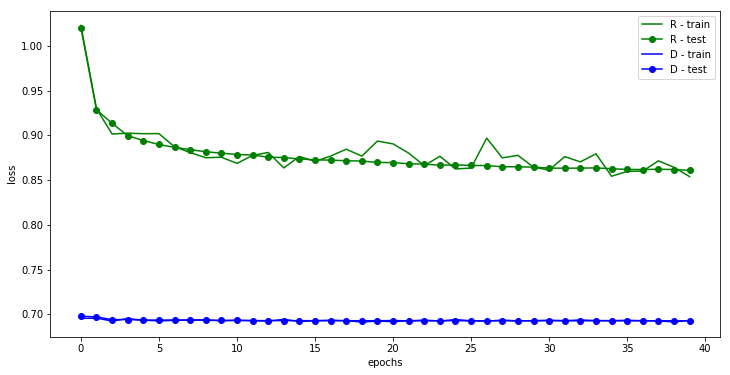

Train Epoch: 41 [0/50000 (0%)]	Losses  R = 0.8530, D = 0.6929
Train Epoch: 41 [10000/50000 (20%)]	Losses  R = 0.8476, D = 0.6935
Train Epoch: 41 [20000/50000 (40%)]	Losses  R = 0.8547, D = 0.6935
Train Epoch: 41 [30000/50000 (60%)]	Losses  R = 0.8578, D = 0.6925
Train Epoch: 41 [40000/50000 (80%)]	Losses  R = 0.8711, D = 0.6935
Train Epoch: 41 [50000/50000 (100%)]	Losses  R = 0.8624, D = 0.6926


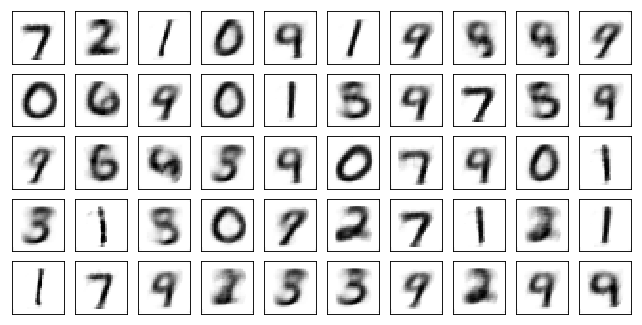

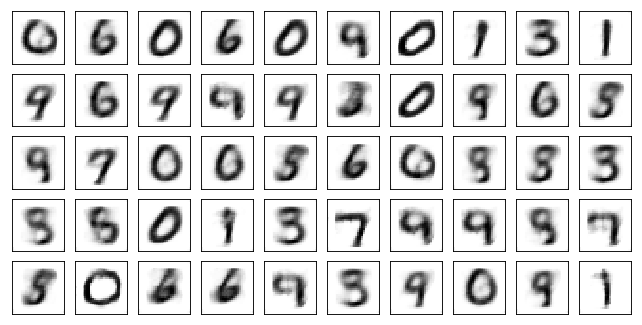

Test losses: 0.8606/0.6929

Train Epoch: 42 [0/50000 (0%)]	Losses  R = 0.8495, D = 0.6928
Train Epoch: 42 [10000/50000 (20%)]	Losses  R = 0.8744, D = 0.6934
Train Epoch: 42 [20000/50000 (40%)]	Losses  R = 0.8684, D = 0.6931
Train Epoch: 42 [30000/50000 (60%)]	Losses  R = 0.8710, D = 0.6936
Train Epoch: 42 [40000/50000 (80%)]	Losses  R = 0.8546, D = 0.6922
Train Epoch: 42 [50000/50000 (100%)]	Losses  R = 0.8542, D = 0.6931


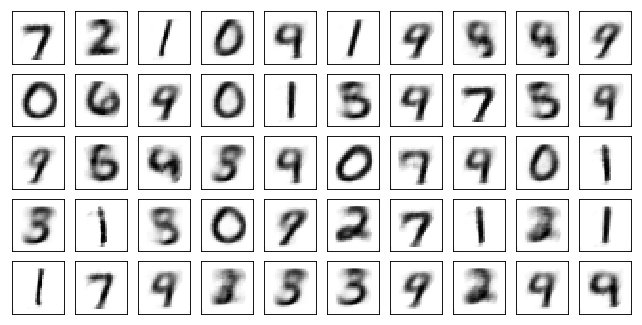

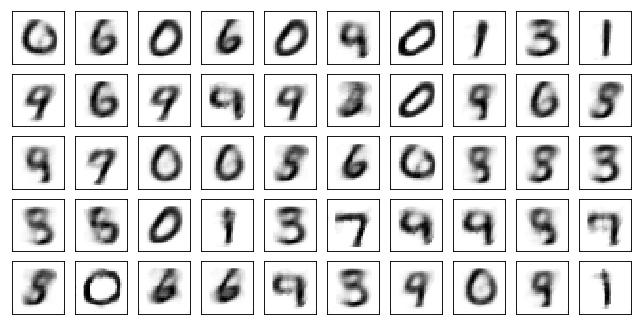

Test losses: 0.8610/0.6928

Train Epoch: 43 [0/50000 (0%)]	Losses  R = 0.8587, D = 0.6927
Train Epoch: 43 [10000/50000 (20%)]	Losses  R = 0.8761, D = 0.6928
Train Epoch: 43 [20000/50000 (40%)]	Losses  R = 0.8526, D = 0.6927
Train Epoch: 43 [30000/50000 (60%)]	Losses  R = 0.8431, D = 0.6931
Train Epoch: 43 [40000/50000 (80%)]	Losses  R = 0.8587, D = 0.6929
Train Epoch: 43 [50000/50000 (100%)]	Losses  R = 0.8664, D = 0.6918


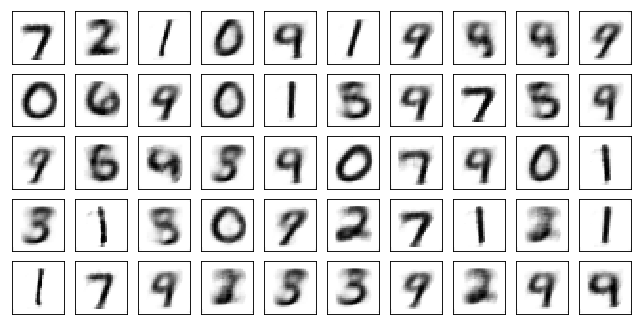

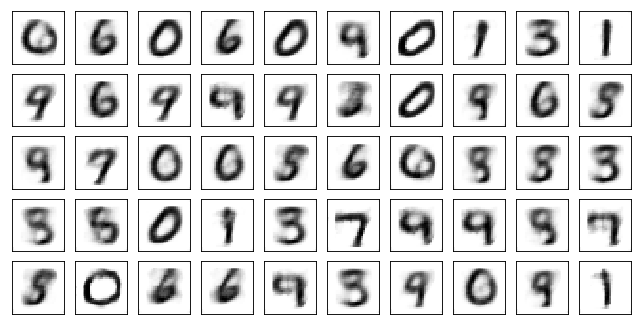

Test losses: 0.8606/0.6929

Train Epoch: 44 [0/50000 (0%)]	Losses  R = 0.8613, D = 0.6924
Train Epoch: 44 [10000/50000 (20%)]	Losses  R = 0.8562, D = 0.6926
Train Epoch: 44 [20000/50000 (40%)]	Losses  R = 0.8459, D = 0.6920
Train Epoch: 44 [30000/50000 (60%)]	Losses  R = 0.8540, D = 0.6933
Train Epoch: 44 [40000/50000 (80%)]	Losses  R = 0.8701, D = 0.6930
Train Epoch: 44 [50000/50000 (100%)]	Losses  R = 0.8610, D = 0.6929


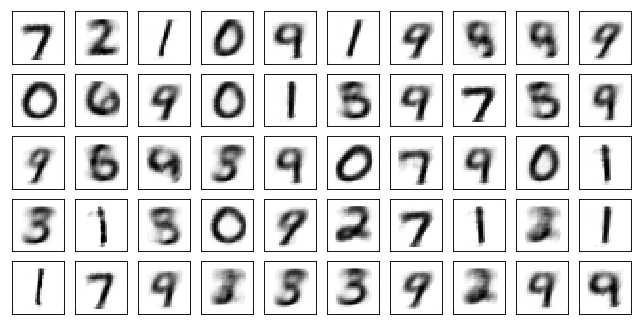

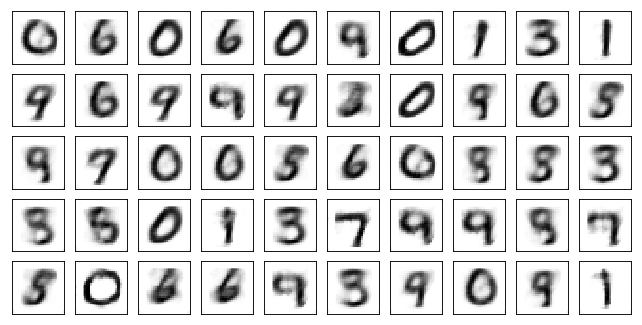

Test losses: 0.8605/0.6929

Train Epoch: 45 [0/50000 (0%)]	Losses  R = 0.8709, D = 0.6928
Train Epoch: 45 [10000/50000 (20%)]	Losses  R = 0.8532, D = 0.6935
Train Epoch: 45 [20000/50000 (40%)]	Losses  R = 0.8670, D = 0.6933
Train Epoch: 45 [30000/50000 (60%)]	Losses  R = 0.8591, D = 0.6928
Train Epoch: 45 [40000/50000 (80%)]	Losses  R = 0.8640, D = 0.6916
Train Epoch: 45 [50000/50000 (100%)]	Losses  R = 0.8503, D = 0.6933


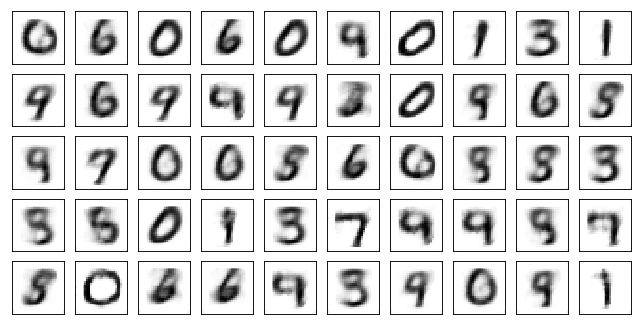

Test losses: 0.8600/0.6928

Train Epoch: 46 [0/50000 (0%)]	Losses  R = 0.8572, D = 0.6929
Train Epoch: 46 [10000/50000 (20%)]	Losses  R = 0.8587, D = 0.6933
Train Epoch: 46 [20000/50000 (40%)]	Losses  R = 0.8525, D = 0.6933
Train Epoch: 46 [30000/50000 (60%)]	Losses  R = 0.8672, D = 0.6924
Train Epoch: 46 [40000/50000 (80%)]	Losses  R = 0.8495, D = 0.6929
Train Epoch: 46 [50000/50000 (100%)]	Losses  R = 0.8535, D = 0.6918


Test losses: 0.8598/0.6930

Train Epoch: 47 [0/50000 (0%)]	Losses  R = 0.8666, D = 0.6933
Train Epoch: 47 [10000/50000 (20%)]	Losses  R = 0.8427, D = 0.6927
Train Epoch: 47 [20000/50000 (40%)]	Losses  R = 0.8450, D = 0.6931
Train Epoch: 47 [30000/50000 (60%)]	Losses  R = 0.8817, D = 0.6921
Train Epoch: 47 [40000/50000 (80%)]	Losses  R = 0.8846, D = 0.6925
Train Epoch: 47 [50000/50000 (100%)]	Losses  R = 0.8594, D = 0.6929


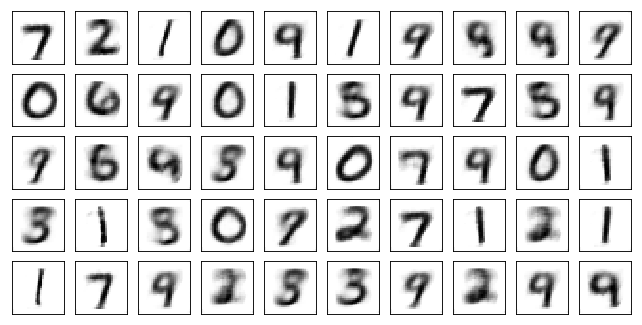

Test losses: 0.8599/0.6928

Train Epoch: 48 [0/50000 (0%)]	Losses  R = 0.8724, D = 0.6922
Train Epoch: 48 [10000/50000 (20%)]	Losses  R = 0.8615, D = 0.6936
Train Epoch: 48 [20000/50000 (40%)]	Losses  R = 0.8452, D = 0.6925
Train Epoch: 48 [30000/50000 (60%)]	Losses  R = 0.8599, D = 0.6913
Train Epoch: 48 [40000/50000 (80%)]	Losses  R = 0.8566, D = 0.6921
Train Epoch: 48 [50000/50000 (100%)]	Losses  R = 0.8571, D = 0.6934


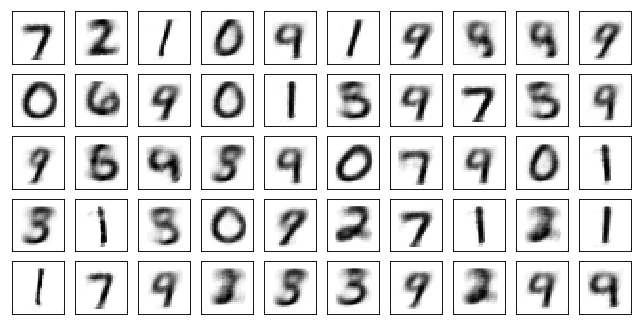

Test losses: 0.8603/0.6928

Train Epoch: 49 [0/50000 (0%)]	Losses  R = 0.8674, D = 0.6931
Train Epoch: 49 [10000/50000 (20%)]	Losses  R = 0.8675, D = 0.6923
Train Epoch: 49 [20000/50000 (40%)]	Losses  R = 0.8585, D = 0.6929
Train Epoch: 49 [30000/50000 (60%)]	Losses  R = 0.8728, D = 0.6926
Train Epoch: 49 [40000/50000 (80%)]	Losses  R = 0.8540, D = 0.6940
Train Epoch: 49 [50000/50000 (100%)]	Losses  R = 0.8623, D = 0.6925


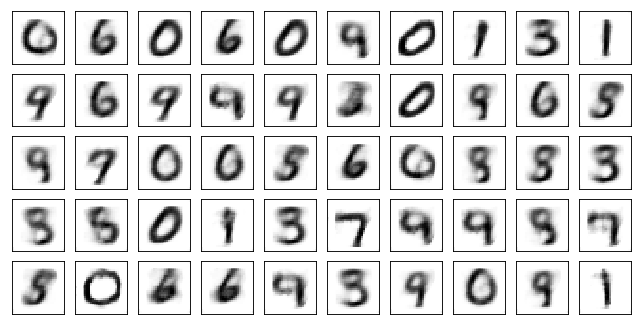

Test losses: 0.8595/0.6929

Train Epoch: 50 [0/50000 (0%)]	Losses  R = 0.8527, D = 0.6924
Train Epoch: 50 [10000/50000 (20%)]	Losses  R = 0.8692, D = 0.6925
Train Epoch: 50 [20000/50000 (40%)]	Losses  R = 0.8571, D = 0.6925
Train Epoch: 50 [30000/50000 (60%)]	Losses  R = 0.8701, D = 0.6917
Train Epoch: 50 [40000/50000 (80%)]	Losses  R = 0.8658, D = 0.6935
Train Epoch: 50 [50000/50000 (100%)]	Losses  R = 0.8421, D = 0.6936


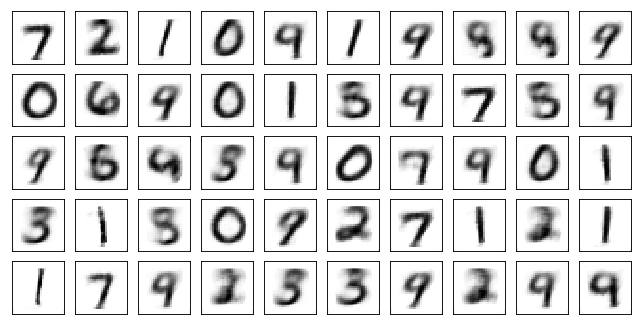

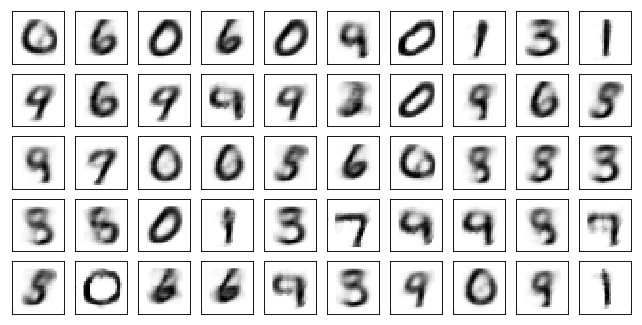

Test losses: 0.8593/0.6928



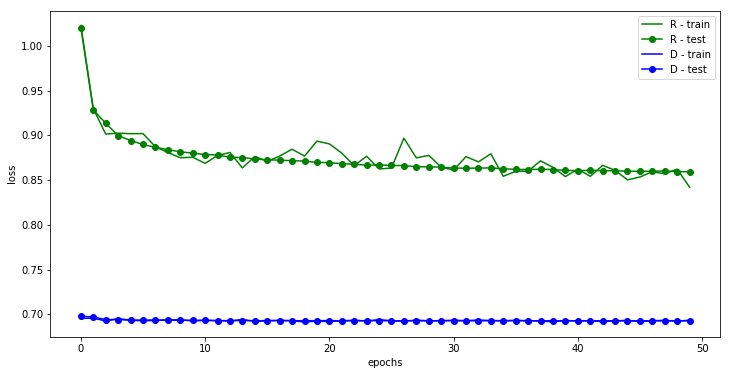

In [17]:
for epoch in range(1, 51):
    encoder.train()
    decoder.train()
    D.train()
    
    train(epoch, train_log)
    
    encoder.eval()
    decoder.eval()
    D.eval()
    
    test(valid_loader, epoch, test_log)
    
    if epoch % 10 == 0:
        plot(list(zip(*train_log)), list(zip(*test_log)))

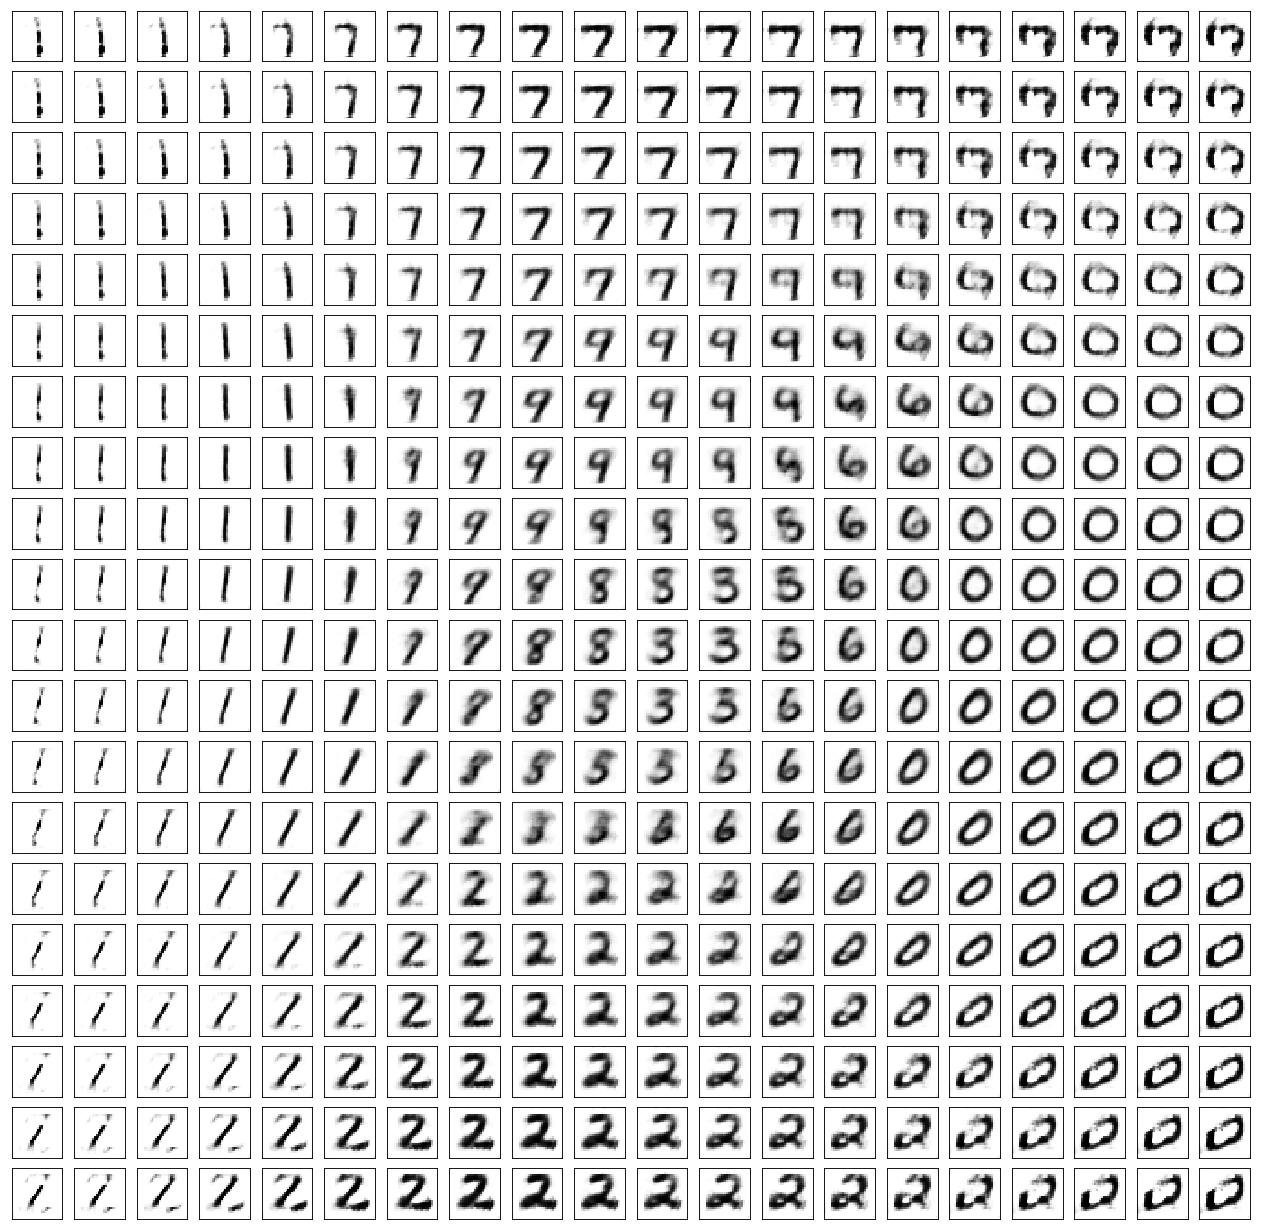

In [18]:
decoder.eval()
n_points = 20
import itertools
data2 = torch.zeros(n_points*n_points,2).cuda()
for t, (i, j) in enumerate(itertools.product(np.linspace(-3,3,n_points),np.linspace(-3,3,n_points))):
    data2[t,:]=torch.tensor((i,j))
dec2 = decoder(data2)
plot_mnist(dec2.detach().cpu().numpy(), (n_points, n_points))